# Prerequisites

Before diving into the actual project, we must make sure that
the environment is properly set up; i.e. the necessary packages
are installed in an isolated environment.

In the project folder, run the following commands in your command-line:

```
python -m venv venv  # creates a virtual environment named "venv"
& ./venv/Scripts/Activate.ps1  # for Windows systems only
python -m pip install -r requirements.txt  # install required packages
```

This will create an isolated virtual environment for your Python project
and install the necessary packages inside it.

The jupyterlab app may be opened via the command:
```
jupyter lab
```

We may now proceed to import the necessary packages.

In [1]:
import typing  # python type-hinting functionality
import ipywidgets  # interactive functionality for jupyter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave

# notebook formatting params, not necessary
# %config InlineBackend.figure_formats = ['svg']  # generate svg plots instead of png
# plt.rcParams.update({"text.usetex": True, "font.family": "serif"})  # prettier text

# Introduction

The Fourier Transform is an interesting bit of math;
it allows us to *decompose* a signal to its constructing signals.
As an example, we will define a function that can generate
sample signals for us to play around with.

In [2]:
def signal(
        f: typing.Callable,
        t: float,
        freq: float = 10,
        rate: int = 2000,
        amp: float = 1) -> np.ndarray:
    """
    Generate a signal from `0` to `t` using the function `f`.

    Parameters
    ----------
    f: function
        The function to generate signal from; Usually sine or cosine.
        Must support vectorization; i.e. accept a vector as input.
    
    t: float
        The signal will be generated between `0` and `t` seconds.
    
    freq: float, optional
        The frequency of the signal in Hz.
        Defaults to 10 Hz.
    
    rate: int, optional
        The sampling rate of the signal in samples/second.
        Defaults to 2000 samples/second.
    
    amp: float, optional
        Amplitude of the signal. Each value generated by `f`
        will be multiplied by this number.
        Defaults to 1.
    
    Returns
    -------
    time: ndarray
        Points at which the signal is evaluated.
    
    values: ndarray
        Value of signal at each point in `time`.
    """
    time = np.linspace( 0, t, np.int64(np.floor(rate * t)) )
    values = amp * f(time * freq)

    return time, values

Here is an interactive demo signal to get a feel for how the function works.

In [3]:
def interactive_signal(t, freq, rate, amp):
    plt.scatter(*signal(np.sin, t, freq, rate, amp), alpha=0.3, s=1)
    plt.ylim(-5, 5)

In [4]:
style = {'description_width': 'initial'}

ipywidgets.interact(
    interactive_signal,
    t = ipywidgets.IntSlider(min=1, max=20, step=1, value=10, description="Time (s)", style=style),
    freq = ipywidgets.IntSlider(min=1, max=20, step=1, value=10, description="Frequency (Hz)", style=style),
    rate = ipywidgets.Dropdown(options=[50, 100, 2000, 44100, 48000, 192000], description="Sampling Rate", style=style),
    amp = ipywidgets.FloatSlider(min=1, max=5, step=0.1, value=2, description="Amplitude", style=style)
    );

interactive(children=(IntSlider(value=10, description='Time (s)', max=20, min=1, style=SliderStyle(description…

Now lets generate some signals.

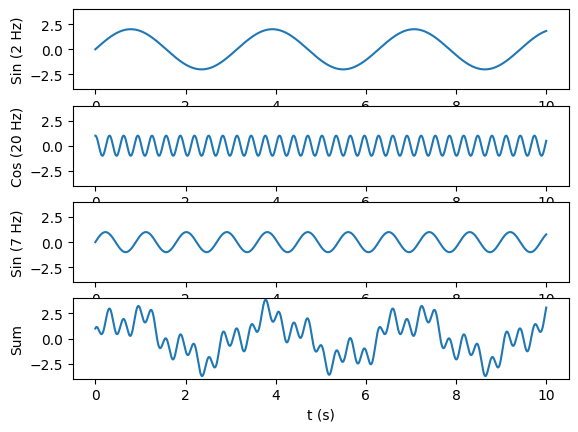

In [5]:
# generate a sine signal
x, y1 = signal(np.sin, 10, freq=2, amp=2)
plt.subplot(4, 1, 1)
plt.plot(x, y1)
plt.ylim(-4, 4)
plt.ylabel("Sin (2 Hz)")

# generate a cosine signal
_, y2 = signal(np.cos, 10, freq=20)
plt.subplot(4, 1, 2)
plt.plot(x, y2)
plt.ylim(-4, 4)
plt.ylabel("Cos (20 Hz)")

# sinusoid with odd frequency
_, y3 = signal(np.sin, 10, freq=7)
plt.subplot(4, 1, 3)
plt.plot(x, y3)
plt.ylim(-4, 4)
plt.ylabel("Sin (7 Hz)")

# generate the sum of three
y = y1 + y2 + y3
plt.subplot(4, 1, 4)
plt.plot(x, y)
plt.ylim(-4, 4)
plt.ylabel("Sum")
plt.xlabel("t (s)")

plt.show()

The last signal is the sum of the other two. The Fourier Transform algorithm 
receives as input the last signal and returns the necessary information
to reconstruct the initial signals.

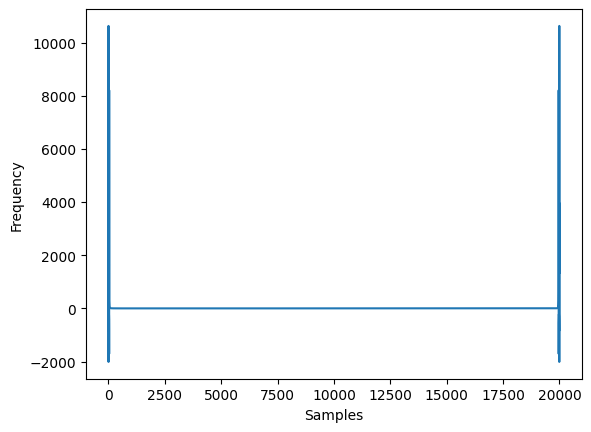

In [6]:
y_transformed = np.fft.fft(y)
plt.plot(y_transformed.real)  # complex values omitted for plotting

plt.xlabel("Samples")
plt.ylabel("Frequency")

plt.show()

Lets zoom in a bit to see what's really happening.

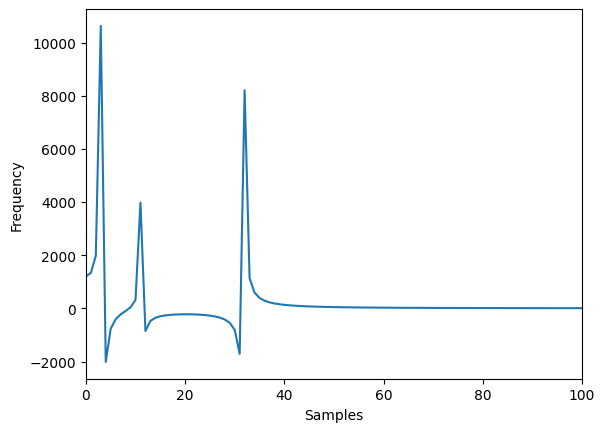

In [7]:
plt.plot(y_transformed.real)

plt.xlabel("Samples")
plt.ylabel("Frequency")
plt.xlim(0, 100)

plt.show()

We can see that the values near the beginning and end have some spikes, 
and the rest are just near zero. It is these spikes that give us the necessary
information to reconstruct the initial signals.

For a beautiful explanation on why this is the case, I highly encourage
you to check out this video by Grant Sanderson (3Blue1Brown).

In [8]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/spUNpyF58BY" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

An important consequence of this is the fact that by storing the spike values, and
just setting the rest of the array to zero; we can have a huge saving on memory and
still be able to reconstruct the original signal.

Lets define a function that does this for us; i.e. set all the low values to zero
(trims them).

In [9]:
def trimmer(A, keep = 0.1):
    """
    Trims the values of `A`, only keeping the highest (`keep * 100`)% of
    the values, setting the rest to zero.

    Parameters
    ----------
    A: ndarray
        Multi-dimensional array of input.
    
    keep: float, optional
        Ratio of values to keep. Must be between 0 and 1.
        Defaults to 0.1.
    
    Returns
    -------
    A_trimmed: ndarray
        The trimmed version of A, with values low values set to zero.
    """
    # vectorize A
    v = A.reshape(-1)

    # sort by magnitude
    v_sorted = np.sort(np.abs(v))

    # find the threshold; anything below which will be set to zero
    threshold_index = (1-keep) * len(v_sorted)
    threshold_index = int(np.floor(threshold_index))  # indices must be integers
    threshold = v_sorted[threshold_index]

    # trim values smaller than `threshold`
    trim_indices = np.abs(A) > threshold  # boolean array of indices
    A_trimmed = A * trim_indices

    return A_trimmed

Having written our function, we may use it to trim our transformed signal.
The widget below will display the regenerated signal for different trim values.

In [10]:
def interactive_ifft(x, y, y_transformed, keep_percent):
    y_transformed_trimmed = trimmer(y_transformed, keep=keep_percent/100)
    y_approx = np.fft.ifft(y_transformed_trimmed)
    
    plt.plot(x, y, label="Original Signal", alpha=0.5)
    plt.plot(x, y_approx, label="Reconstructed Signal", alpha=0.5)
    
    # plot parameters
    plt.ylim(-4, 4)
    plt.xlabel("t (s)")
    plt.ylabel("Signal Amplitude")
    plt.legend(loc=3)

In [11]:
ipywidgets.interact(
    interactive_ifft,
    x = ipywidgets.fixed(x),
    y = ipywidgets.fixed(y),
    y_transformed = ipywidgets.fixed(y_transformed),
    keep_percent = ipywidgets.FloatSlider(min=0.01, max=2, value=1, step=0.01, description="Keep %")
    );

interactive(children=(FloatSlider(value=1.0, description='Keep %', max=2.0, min=0.01, step=0.01), Output()), _…

We can see that the reconstructed compressed signal is pretty much the same as the original.

**Great! But how does that help in compressing images?**

An image can essentially be viewed as multiple rows/columns of signals.
We may apply the fourier transform along 2-dimensions (or any number of dimensions, really)
by applying it row by row and then column by column.

NumPy has a really convenient function, called `fft2` which does exactly this for us.

Moving forward, the image we will be working on is a picture of our dear and beloved Albert.

Image size: (679, 800)


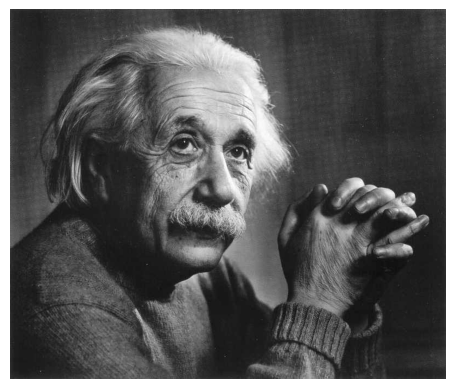

In [12]:
img = imread("images/einstein.jpg")
print(f"Image size: {img.shape}")

plt.imshow(img, cmap="gray")
plt.axis("off");

### Side Note

The main Discrete Fourier Transform (DFT) formula is written below:

$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i 2 \pi k n / N}
$$

This formula has a runtime order of $O(N^2)$, which is a lot; simply
running it on the image above with 679x800 pixels took more than an hour
to complete. Our compression and decompression algorithms need to be fast, 
so that when we open a picture on our mobile, it happens instantly. That's where
the Fast Fourier Transform (FFT) algorithms come to play; the most famous
of which is the Cooley-Tukey algorithm[^1]. This is a divide and conquer algorithm
with a runtime order of $O(N \log N)$—a huge improvement.

Due to the depth and complexity of the algorithm, we will not try to implement it; NumPy already has a 
`fft` module that perfectly fits our needs.

[^1]: Cooley, James W.; Tukey, John W. (1965). ["An algorithm for the machine calculation of complex Fourier series"](https://doi.org/10.2307%2F2003354). Math. Comput. 19 (90): 297–301. doi:10.2307/2003354.

In [13]:
## number of operations required for the DFT of Einstein's image ##

# one row
row = 800 * 800
entire_rows = 679 * row

# one column
col = 679 * 679
entire_cols = 800 * col

# total operations needed
entire_rows + entire_cols

803392800

# The (Fast!) Fourier Transform of an Image

Putting together what we've coded so far,
we will define a function that will wrap around all our code and
simplifies it down to receiving an input image path and compression
ratio, and outputing the compressed image.

In [14]:
def compressor(path: str, ratio: float = 90.0) -> np.ndarray:
    """
    Compresses the given image according to compression `ratio`.

    Parameters
    ----------
    path: str
        The location of input image in the filesystem.
    
    ratio: float, optional
        The compression rate of image, given in percentage (0 to 100).

    Returns
    -------
    img_compressed: ndarray
        The compressed image.
    """
    img = imread(path)
    img_freq = np.fft.fft2(img)
    img_freq_trimmed = trimmer(img_freq, keep=1-ratio/100)
    img_compressed = np.fft.ifft2(img_freq_trimmed).real

    return img_compressed

We can test the result of different compression ratios using the interactive widgets
provided by the `ipywidgets` package. If you are 
viewing the notebook's PDF format, the outputs below may not make 
a whole lot of sense to you. I highly encourage you to open the
otebook file in the jupyterlab environment and test the different outputs for yourself.

In [15]:
def interactive_compressor(path: str, ratio: float = 90.0):
    """
    Utility function for plotting of generated images by
    the `compressor` function.
    """
    img_compressed = compressor(path, ratio)
    
    plt.imshow(img_compressed, cmap="gray");
    plt.axis("off");

In [16]:
ipywidgets.interact(
    interactive_compressor,
    path = "images/einstein.jpg",
    ratio = ipywidgets.IntSlider(min=0, max=99, step=1, value=90)
    );

interactive(children=(Text(value='images/einstein.jpg', description='path'), IntSlider(value=90, description='…

We can see that for compression rates below 90%, hardly anything changes. 
A more fine-tuned slider is provided below.

In [17]:
ipywidgets.interact(
    interactive_compressor,
    path = "images/einstein.jpg",
    ratio = ipywidgets.FloatSlider(min=95.00, max=99.99, step=0.01, value=99.50)
    );

interactive(children=(Text(value='images/einstein.jpg', description='path'), FloatSlider(value=99.5, descripti…

# Size Comparisons

*A sparse matrix is a matrix that is comprised of mostly zero values.*

... and a Fourier transformed signal contains a whole bunch of zeros—Great!
We can use this data structure to store the transformed image in an efficient manner, 
thereby **compressing** the image.

Thankfully, SciPy provides a whole module for us related to 
sparse matrices; we will use its `csr_matrix` data structure.

In [18]:
from scipy.sparse import csr_matrix

In [19]:
img_transformed = np.fft.fft2(img).real
img_trimmed = trimmer(img_transformed, keep = 0.05)  # 95% compression ratio
img_sparse = csr_matrix(img_trimmed)

img_sparse

<679x800 sparse matrix of type '<class 'numpy.float64'>'
	with 27159 stored elements in Compressed Sparse Row format>

We can compare the sizes occupied by the original and sparse image.

In [20]:
img.nbytes

543200

In [21]:
img_sparse.data.nbytes

217272

The size has been almost halved.

# Final Bits

We began by defining what a Fourier Transform is, and how it may be used to 
compress a signal in the frequency domain. We then proceeded to define images 
as rows and columns of signals, thereby allowing ourselves to apply Fourier Transforms
to them. We also noted that the "default" Fourier Transform function is quite slow
with an order of $O(N^2)$, and introduced the ingenious Fast Fourier Transform
algorithm created by Cooley and Tukey. Finally, we gathered all our gained knowledge
into a single `compressor` function that compressed our input image for us and viewed 
the different results produced by applying different compression ratios.

The rest of the code written below is only for saving some sample
compressed images and has no significant scientific and/or insight value.

In [22]:
path = "images/einstein.jpg"
ratios = [80.00, 90.00, 95.00, 99.00, 99.50, 99.90]

for ratio in ratios:
    img_compressed = compressor(path, ratio)
    imsave(f"{path[:-4]}-{ratio}.jpg", img_compressed, cmap="gray")

# Resources

* [Generation of Basic Signals](https://xn--llions-yua.jutge.org/upc-python-cookbook/signal-processing/signals.html) by Víctor Adell
* [But what is the Fourier Transform?](https://youtu.be/spUNpyF58BY) by Grant Sanderson
* [Fourier Analysis - Data-Driven Science and Engineering](https://www.youtube.com/playlist?list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC) by Steve Brunton